# Exploratory Data Analysis for Product Classification

The purpose of using a notebook for dataset analysis is to better visualise the dataset and understand which preprocessing is suitable for it. 

In [2]:
# Configuration
import gzip
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from wordcloud import WordCloud
import networkx as nx


sns.set(style="whitegrid")

In [3]:
# Functions:

# Function to load the compressed JSONL file
def parse_data(path):
    """Reads a compressed JSONL file line by line."""
    with gzip.open(path, 'r') as f:
        for line in f:
            yield json.loads(line)

def load_data(path, limit=None, seed=42):
    """
    Loads a JSONL dataset into a pandas DataFrame, randomly selecting rows if a limit is applied.
    
    Args:
        path (str): Path to the .jsonl.gz file.
        limit (int, optional): Maximum number of rows to load for testing.
        seed (int, optional): Seed for random selection reproducibility.
    
    Returns:
        pd.DataFrame: Dataset loaded as a DataFrame.
    """
    if limit is None:
        # Load all rows if no limit is applied
        return pd.DataFrame(parse_data(path))
    
    random.seed(seed)  # Set a seed for reproducibility
    selected_data = []
    total_count = 0

    # Iterate line by line and randomly select rows until the limit is reached
    for record in parse_data(path):
        total_count += 1
        if len(selected_data) < limit:
            selected_data.append(record)
        else:
            # Replace an element with probability `limit / total_count`
            idx = random.randint(0, total_count - 1)
            if idx < limit:
                selected_data[idx] = record

    return pd.DataFrame(selected_data)

In [4]:
# Dataset path
DATA_PATH = '../data/raw/amz_products_small.jsonl.gz'

# Load data (use a limit for testing)

df = load_data(DATA_PATH) # Takes time; use with limit for testing
# df = load_data(DATA_PATH, limit=100000)


# Dataset summary
print("Resumen del dataset:")
print(df.info())
print("Shape of dataset:", df.shape)

# Display first rows of the dataset
df.head()

Resumen del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1248417 entries, 0 to 1248416
Data columns (total 11 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   also_buy     1248417 non-null  object
 1   also_view    1248417 non-null  object
 2   asin         1248417 non-null  object
 3   brand        1248417 non-null  object
 4   category     1248417 non-null  object
 5   description  1248417 non-null  object
 6   feature      1248417 non-null  object
 7   image        1248417 non-null  object
 8   price        1248417 non-null  object
 9   title        1248417 non-null  object
 10  main_cat     1248417 non-null  object
dtypes: object(11)
memory usage: 104.8+ MB
None
Shape of dataset: (1248417, 11)


,also_buy,also_view,asin,brand,category,description,feature,image,price,title,main_cat
0,[],[],B00ADZ3WUM,NSI,"[Automotive, Exterior Accessories, Bumper Stic...",[Bumpersticker: A day without sunshine is like...,[Official Licensed Die-Cut Sticker Designed by...,[],$4.68,"NSI - A Day Without Sunshine is Like, Well, Ni...",Automotive
1,[],[],B005VII5IU,General Motors,"[Automotive, Replacement Parts, Body & Trim, B...",[This is the official Genuine General Motors P...,[This is the official Genuine General Motors P...,[],$213.16,Genuine GM Parts 10341533 Rear Bumper Valance ...,Automotive
2,[],[],B001QTEKVO,JLM,"[Automotive, Lights & Lighting Accessories, Li...",[HID Xenon lights are designed to be at least ...,"[Will run for approx 2500 hours, Produces 2 to...",[https://images-na.ssl-images-amazon.com/image...,,JLM HID Conversion Kit H13 (9008) Dual Tube B...,Automotive
3,[],"[B007KLMLRM, B007KLMNNE, B0085FOJ90, B0085FOAW...",B00HWI43Q0,Spec-D Tuning,"[Automotive, Lights & Lighting Accessories, Li...",[Brand new in original packaging. Exactly the ...,[Features 1 pair of Red & Smoked lens Tail Lig...,[https://images-na.ssl-images-amazon.com/image...,$8.63,Spec-D Tuning LT-E362RG-F2-APC New 3D Light Ba...,Automotive
4,[],[],B0050VHRFK,Oracle Lighting,"[Automotive, Replacement Parts, Switches & Rel...",[Oracle Flush LED switches combines styling an...,"[Heavy stainless steel construction, LED illum...",[https://images-na.ssl-images-amazon.com/image...,$19.95,Oracle Lighting LSGQ16FW White LED On/Off Flus...,Automotive


General structure of the dataset:
- 11 columns
- All columns of type ‘object’.
- No missing values
- 1,248,417 records

C:\Users\00jav\AppData\Local\Temp\ipykernel_19200\4059586892.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=main_cat_distribution.index, y=main_cat_distribution.values, palette="viridis")


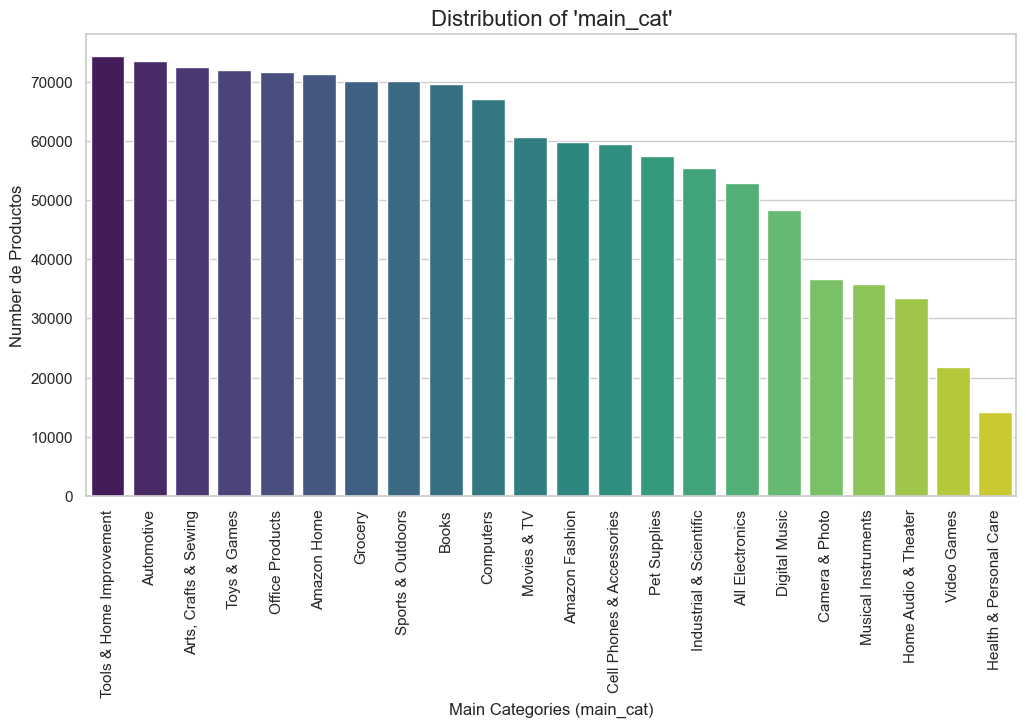

In [5]:
# Distribution de main_cat
main_cat_distribution = df['main_cat'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=main_cat_distribution.index, y=main_cat_distribution.values, palette="viridis")
plt.title("Distribution of 'main_cat'", fontsize=16)
plt.ylabel("Number de Productos")
plt.xlabel("Main Categories (main_cat)")
plt.xticks(rotation=90)
plt.show()

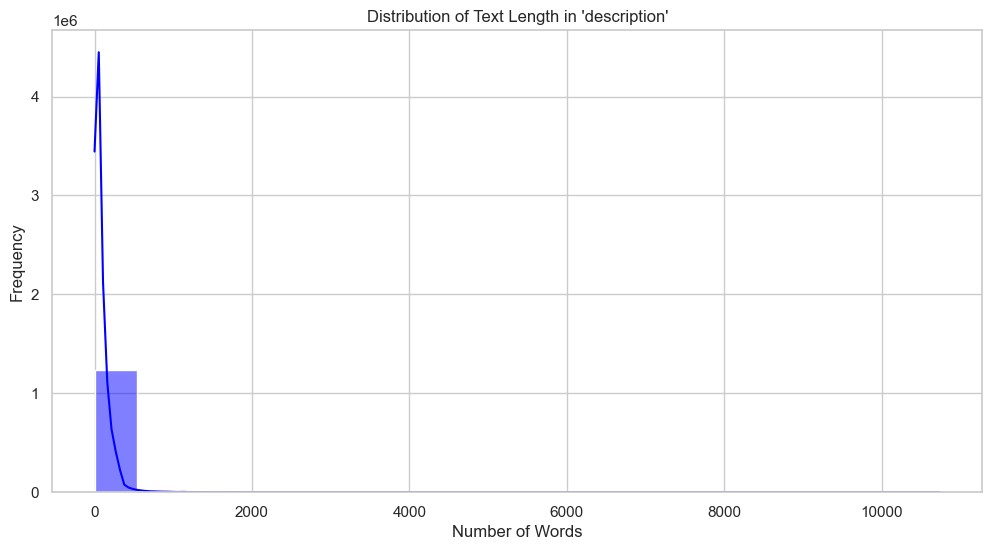

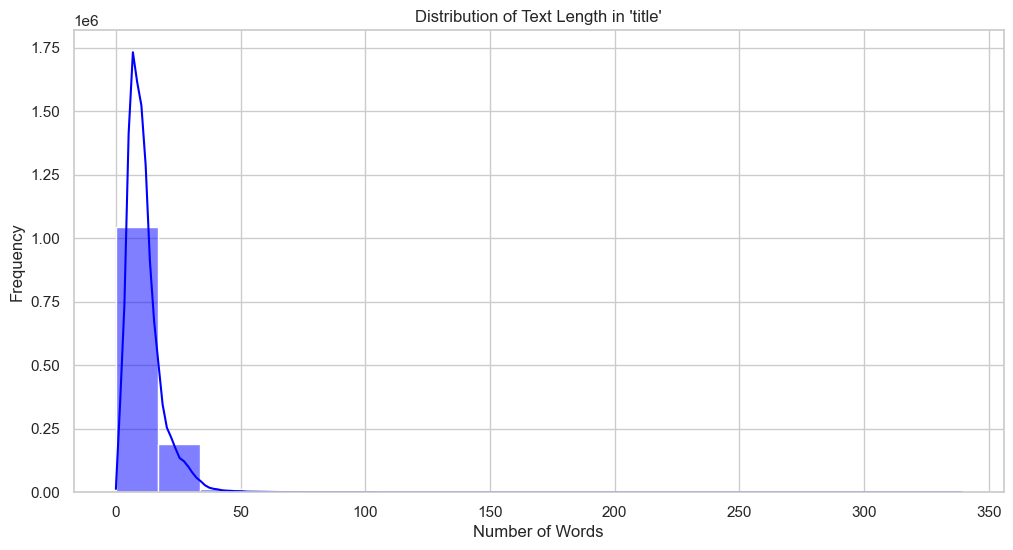

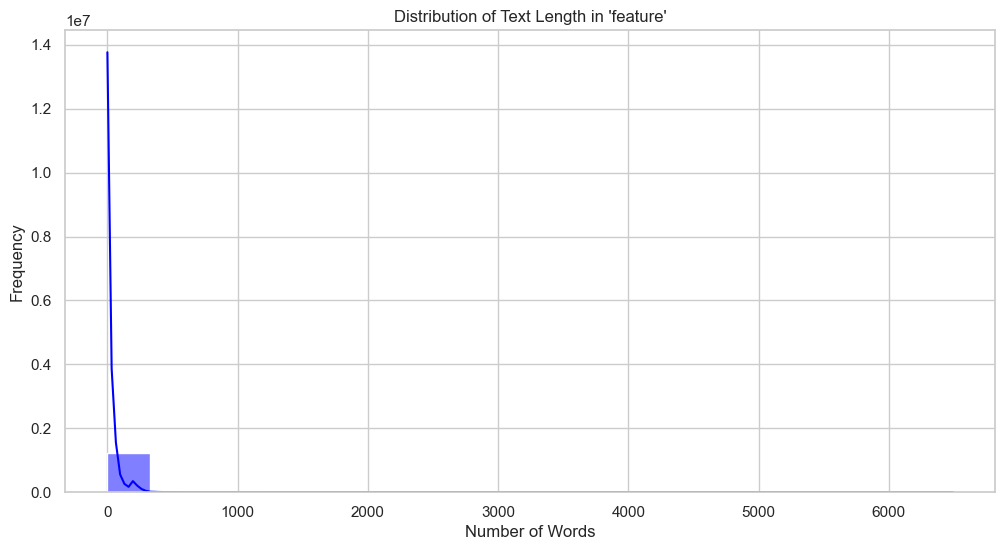

In [6]:
# Ensure that `description`, `feature`, and `title` are strings
df['description'] = df['description'].apply(lambda x: " ".join(x) if isinstance(x, list) else x)
df['feature'] = df['feature'].apply(lambda x: " ".join(x) if isinstance(x, list) else x)

# Text Length Analysis
columns_to_analyze = ['description', 'title', 'feature']
for col in columns_to_analyze:
    df[f'{col}_len'] = df[col].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

    plt.figure(figsize=(12, 6))
    sns.histplot(df[f'{col}_len'], kde=True, bins=20, color='blue')
    plt.title(f"Distribution of Text Length in '{col}'")
    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")
    plt.show()

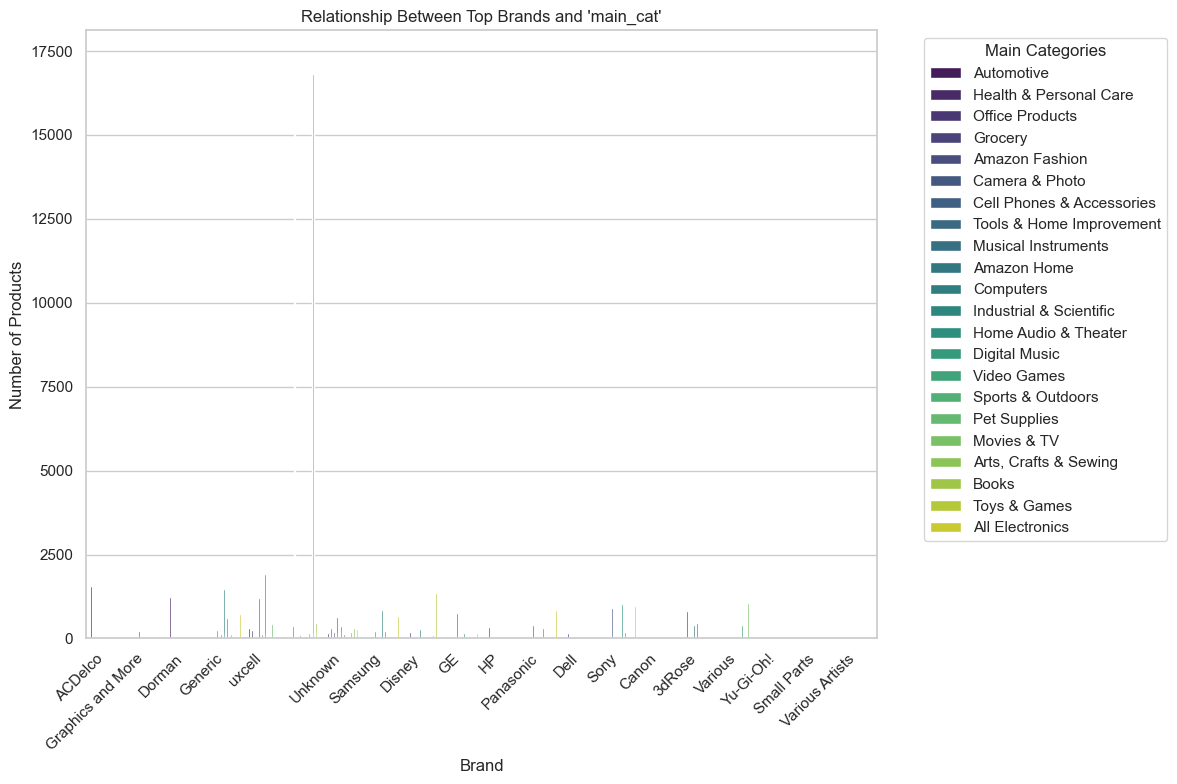

In [7]:
# Count the most frequent brands
top_brands_count = 20  # Adjust the number of top brands to analyze
top_brands = df['brand'].value_counts().head(top_brands_count).index

# Filter the dataset to include only the most frequent brands
filtered_df = df[df['brand'].isin(top_brands)]

# Stacked bar chart to show the relationship between 'brand' and 'main_cat'
plt.figure(figsize=(12, 8))
sns.countplot(data=filtered_df, x='brand', hue='main_cat', palette='viridis')
plt.title("Relationship Between Top Brands and 'main_cat'")
plt.xlabel("Brand")
plt.ylabel("Number of Products")
plt.xticks(rotation=45, ha="right")
plt.legend(title='Main Categories', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Unique values in 'price': ['$4.68' '$213.16' '' ... '$160.50' '$179.59' '$3,199.00']


C:\Users\00jav\AppData\Local\Temp\ipykernel_19200\1819015748.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  invalid_prices = df[~df['price'].str.replace('.', '', regex=False).str.isnumeric().fillna(True)]


Problematic values in 'price':
                                                   also_buy  \
173                                                     []   
389                                                     []   
434                                                     []   
449                                                     []   
452                                                     []   
...                                                    ...   
1248079                                                 []   
1248130  [B000GB8QN6, B004M8M2M0, B0015Z1I0A, B000ERVM5...   
1248141  [B009DZTXQU, B00L9OPPMO, B00N23Z8VI, B004QEWVL...   
1248231                                                 []   
1248388                                                 []   

                                                 also_view        asin  \
173                                                     []  B00SMX7WN0   
389                   [B000COUMBG, B000HLT0SK, B00029JKA0]  B000COW6C4   
4

C:\Users\00jav\AppData\Local\Temp\ipykernel_19200\1819015748.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['price'], palette="Set2")


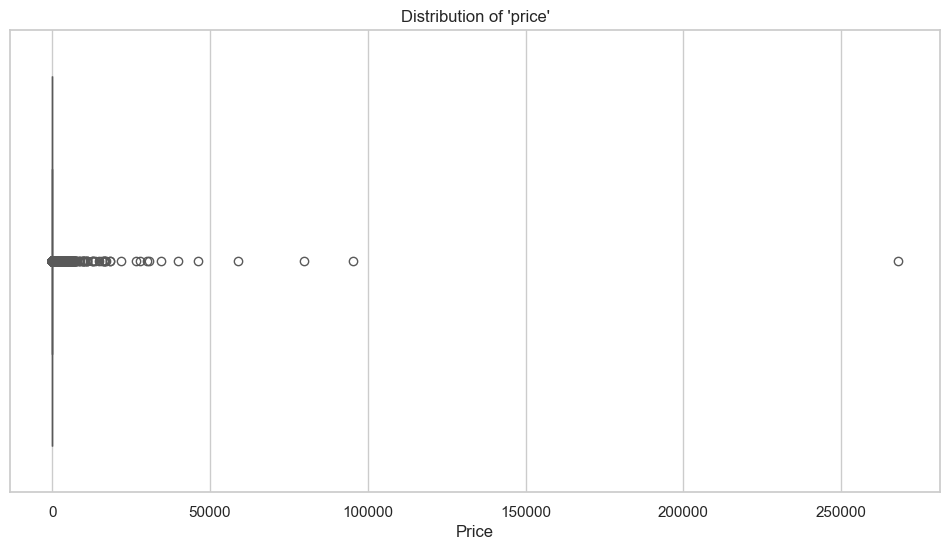

In [8]:
# Price Distribution
# Inspect unique values in the 'price' column
print("Unique values in 'price':", df['price'].unique())

# Clean the 'price' column
df['price'] = (
    df['price']
    .str.strip()  # Remove whitespace
    .str.replace('[\$,]', '', regex=True)  # Remove symbols like $ and commas
    .replace(['', 'N/A', 'NaN'], np.nan)  # Replace invalid strings with NaN
)

# Identify problematic values
invalid_prices = df[~df['price'].str.replace('.', '', regex=False).str.isnumeric().fillna(True)]
print("Problematic values in 'price':\n", invalid_prices)

# Convert to float (ensuring no unconvertible values remain)
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Visualize the price distribution
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['price'], palette="Set2")
plt.title("Distribution of 'price'")
plt.xlabel("Price")
plt.show()

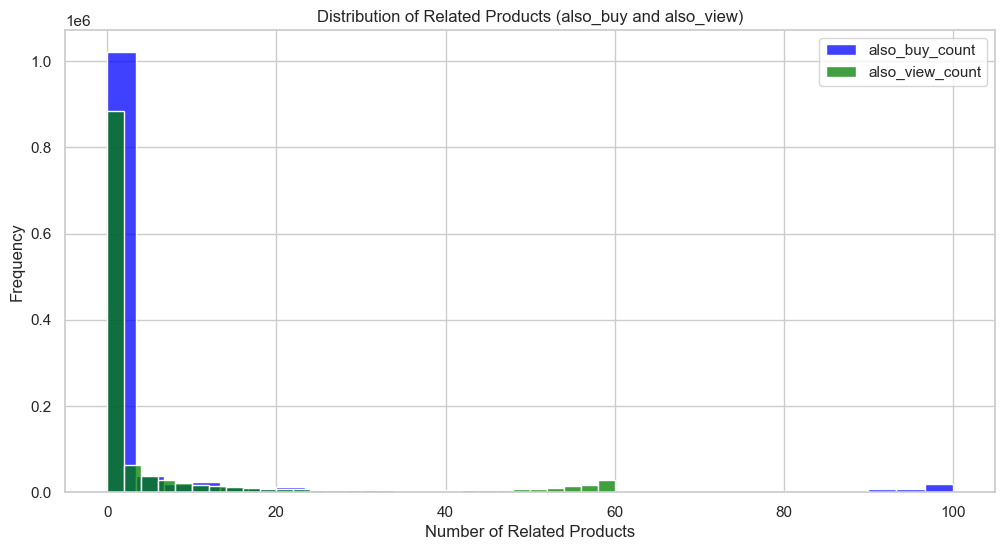

In [9]:
# Characteristics of also_buy and also_view
df['also_buy_count'] = df['also_buy'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df['also_view_count'] = df['also_view'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Visualize the distribution of related products
plt.figure(figsize=(12, 6))
sns.histplot(df['also_buy_count'], bins=30, kde=False, color='blue', label='also_buy_count')
sns.histplot(df['also_view_count'], bins=30, kde=False, color='green', label='also_view_count')
plt.title("Distribution of Related Products (also_buy and also_view)")
plt.xlabel("Number of Related Products")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Attempting to create a graph was computationally expensive and returned missing values.

In [10]:
# Create a graph of relationships with NetworkX
G = nx.Graph()

# Add nodes and also_buy relationships
for idx, row in df.iterrows():
    if isinstance(row['also_buy'], list):
        for related_asin in row['also_buy']:
            G.add_edge(row['asin'], related_asin, relation='also_buy')

# Add also_view relationships
for idx, row in df.iterrows():
    if isinstance(row['also_view'], list):
        for related_asin in row['also_view']:
            G.add_edge(row['asin'], related_asin, relation='also_view')

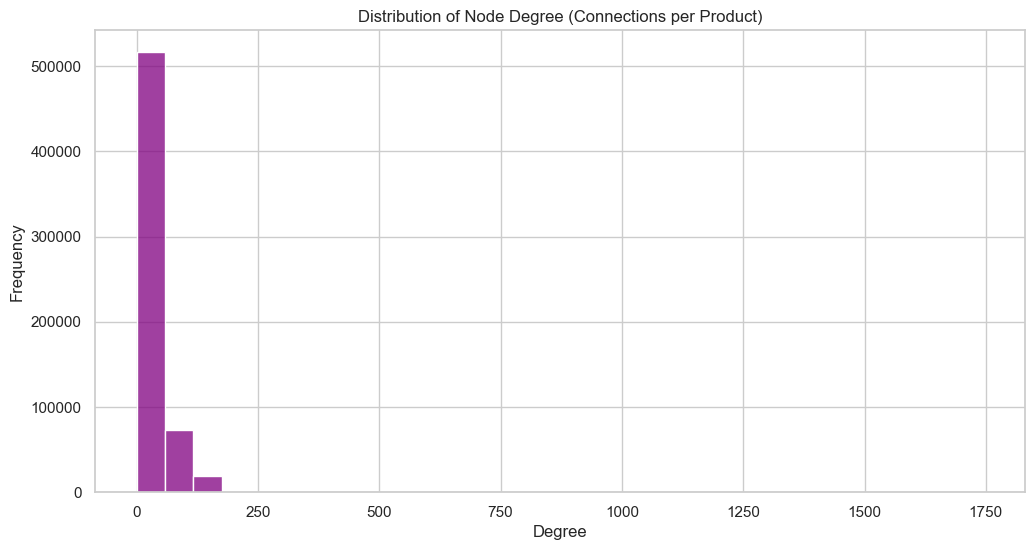

In [11]:
# Calculate derived graph features
# Node degree (number of connections per product)
degree_dict = dict(G.degree())
df['degree'] = df['asin'].map(degree_dict)

# Visualize graph metrics
# Node degree distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['degree'], bins=30, kde=False, color='purple')
plt.title("Distribution of Node Degree (Connections per Product)")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()
